---
title: Sentinel-2 L1C MSI Zarr Product Exploration
subtitle: Explore how to open, visualise and plot Sentinel-2 L1C MSI EOPF Zarr format
authors:
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Suriyah Dhinakaran
    orcid: 0009-0007-0355-7372
    github: suriyahgit
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-03-21
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords: ["xarray", "earth observation", "remote sensing"]
tags: ["sentinel-2", "xarray", "land"]
releaseDate: 2025-03-21
datePublished: 2025-03-21
dateModified: 2025-05-27
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents
1. [Introduction](#Introduction)  
2. [Import modules](#Import-modules)  
3. [EOPF: Open the product](#Open-the-product)  
4. [EOPF: Overview of the product content](#Overview-of-the-product-content)  
5. [EOPF: Plot a RGB image](#Plot-a-RGB-image)
6. [SAFE: Open the product](#Open-the-product)  
7. [SAFE: Overview of the product content](#Overview-of-the-product-content)  
8. [SAFE: Plot a RGB image](#Plot-a-RGB-image)  



## Introduction

This notebook demonstrates how to open, explore, and visualize Sentinel-2 Level 1C MSI products stored in EOPF Zarr format, including plotting RGB images and analyzing geolocation data.

:::{hint} Overview
**Questions**
- How do I access Sentinel-2 L1C in EOPF Zarr format?
- How can I plot the Sentinel-2 tile location on a map?
- How do I plot a RGB image of the selected scene?

**Objectives**
- Being able to open a Sentinel-2 L1C EOPF Zarr product from an object storage
- Understanding the product structure and how to get specific bands
:::

## Import modules

In [1]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## EOPF: Open the product


In [2]:
remote_product_path = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458.zarr"
dt = xr.open_datatree(remote_product_path, engine="zarr", chunks={})

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_144024/3026331891.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(remote_product_path, engine="zarr", chunks={})
/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_144024/3026331891.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a 

## EOPF: Overview of the product content

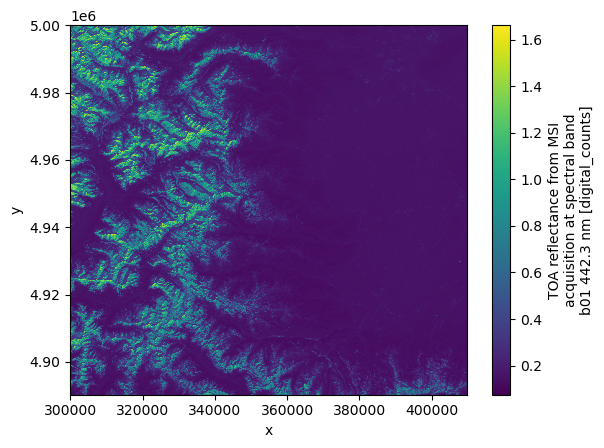

In [3]:
dt["measurements/reflectance/r60m"]["b01"].plot()
# Alternative notation
# dt.measurements.reflectance.r60m.b01.plot()

The original data is stored in `uint16`, with scale and offset values to be applied manually.  
Xarray applies the scale and offset automatically, providing `reflectance` values by default.  
You can still get the original Digital Numbers (DNs) in `uint16` by setting the `mask_and_scale = False` parameter when opening the product, e.g.:

```python
dt = xr.open_datatree(remote_product_path, engine="zarr", chunks={}, mask_and_scale=False)
```

We can get some info about the oroginal encoding with the following code:

In [20]:
dt["measurements/reflectance/r60m"]["b01"].encoding

{'chunks': (305, 305),
 'preferred_chunks': {'y': 305, 'x': 305},
 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': 0,
 'scale_factor': 0.0001,
 'add_offset': -0.1,
 'dtype': dtype('uint16')}

If we are interested in some band statistics, they can easily be computed using the xarray methods.  
Remember that calling `.compute()` triggers the data download and processing of the result.

In [21]:
min, max, mean = (
    dt["measurements/reflectance/r60m"]["b01"].data.max(),
    dt["measurements/reflectance/r60m"]["b01"].data.min(),
    dt["measurements/reflectance/r60m"]["b01"].data.mean(),
)
min.compute(), max.compute(), mean.compute()

(1.6631, 0.0746, 0.27504428200304576)

## EOPF: Plot a RGB image


We can compose a new object for visualization, taking only the red (b04), green (b03) and blue (b02) bands.

Decimation is also applied, which reduces the data we consider for visualization, speeding up the process. Decimation is performed using the `.isel` xarray method.
```python
.isel(x=slice(None, None, 10), y=slice(None, None, 10))
```

Finally, we rescale the data for a more meaningful visualization.

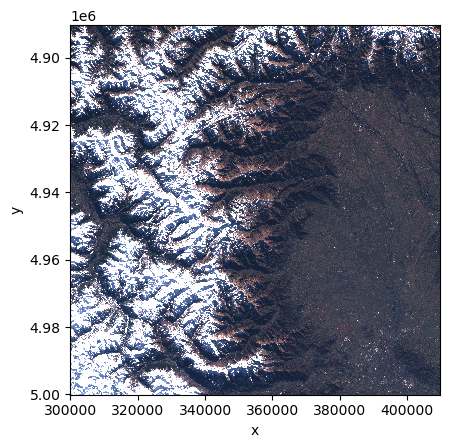

In [22]:
rgb_band_paths = (
    "measurements/reflectance/r10m/b04",
    "measurements/reflectance/r10m/b03",
    "measurements/reflectance/r10m/b02",
)
# Concatenate the selected bands in a single xarray DataArray, applying decimation with a factor of 10
concat = xr.concat(
    [
        dt[str(p)].isel(x=slice(None, None, 10), y=slice(None, None, 10))
        for p in rgb_band_paths
    ],
    dim="band",
)

# Rescale the data for a more meaningful visualization
concat = (concat / 0.4).clip(0, 1)

ax = concat.plot.imshow()
ax.axes.set_aspect("equal")
plt.gca().invert_yaxis()

## Safe

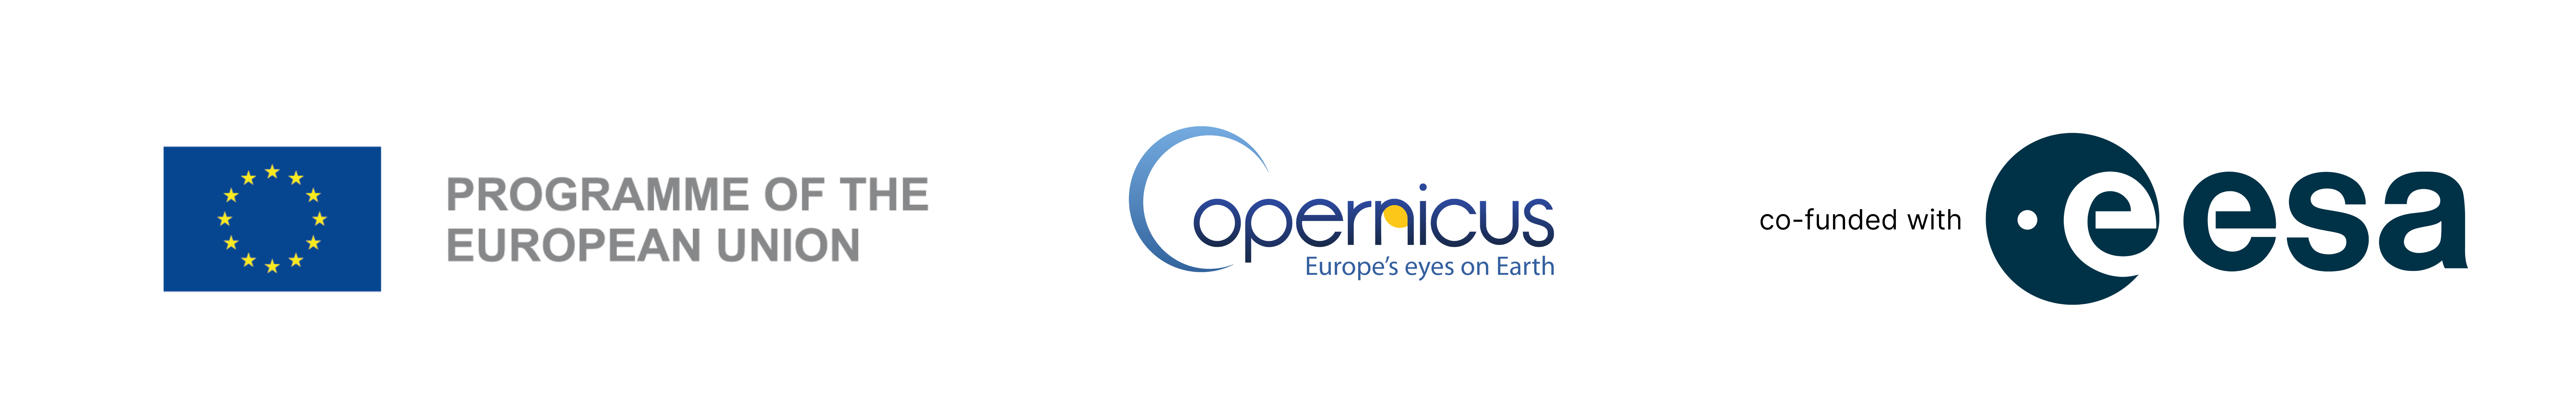